In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/brain_tumor_segmentation_dataset.zip"

!cp -r {path} .


In [4]:
import zipfile

# ZIP dosyasının yolu
zip_file_path = '/content/drive/MyDrive/brain_tumor_segmentation_dataset.zip'
extract_folder_path = '/content/extracted'

# ZIP dosyasını açma ve çıkarma
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)

print(f"Dosyalar çıkarıldı: {extract_folder_path}")

Dosyalar çıkarıldı: /content/extracted


In [5]:
#importation des packages
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
import tensorflow.keras.backend as K

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
print("done")

done


In [6]:
# Chemin d'accès aux données
data_path = "/content/extracted/Brain Tumor Segmentation Dataset"

# Classes des tumeurs
classes = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']

# Initialisation des listes pour stocker les images et les masques
images = []
masks = []
labels = []
# Dimensions souhaitées pour les images et les masques
target_size = (128, 128)

# Chargement des images et des masques
for class_name in classes:
    image_folder = os.path.join(data_path, 'image', str(classes.index(class_name)))
    mask_folder = os.path.join(data_path, 'mask', str(classes.index(class_name)))
    print(image_folder)
    print(mask_folder)
    # Vérification si les dossiers existent
    if os.path.exists(image_folder) and os.path.exists(mask_folder):
        # Chargement des images
        for image_name in tqdm(os.listdir(image_folder), desc=class_name):
            if image_name.endswith('.jpg') or image_name.endswith('.png'):  # Vérification du format
                image_path = os.path.join(image_folder, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, target_size)
                image = image / 255.0

                # Vérification du nom du masque correspondant
                mask_name = image_name.replace('.jpg', '_m.jpg').replace('.png', '_m.png')
                mask_path = os.path.join(mask_folder, mask_name)

                # Chargement du masque seulement s'il existe
                if os.path.exists(mask_path):
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    mask = cv2.resize(mask, target_size)
                    mask = mask / 255.0

                    # Ajout des images et masques aux listes
                    images.append(image)
                    masks.append(mask)
                    labels.append(classes.index(class_name))

                else:
                    print(f"Masque manquant pour l'image: {image_name}")

# Conversion des listes en tableaux NumPy
images = np.array(images).reshape(-1, 128, 128, 1)
masks = np.array(masks).reshape(-1, 128, 128, 1)
labels = np.array(labels)

# Affichage des dimensions des ensembles de données
print(f"Nombre d'images : {len(images)}, Nombre de masques : {len(masks)}, nombre de labels: {len(labels)}")

/content/extracted/Brain Tumor Segmentation Dataset/image/0
/content/extracted/Brain Tumor Segmentation Dataset/mask/0


no_tumor:   0%|          | 0/1595 [00:00<?, ?it/s]

/content/extracted/Brain Tumor Segmentation Dataset/image/1
/content/extracted/Brain Tumor Segmentation Dataset/mask/1


glioma_tumor:   0%|          | 0/649 [00:00<?, ?it/s]

/content/extracted/Brain Tumor Segmentation Dataset/image/2
/content/extracted/Brain Tumor Segmentation Dataset/mask/2


meningioma_tumor:   0%|          | 0/999 [00:00<?, ?it/s]

/content/extracted/Brain Tumor Segmentation Dataset/image/3
/content/extracted/Brain Tumor Segmentation Dataset/mask/3


pituitary_tumor:   0%|          | 0/994 [00:00<?, ?it/s]

Nombre d'images : 4237, Nombre de masques : 4237, nombre de labels: 4237


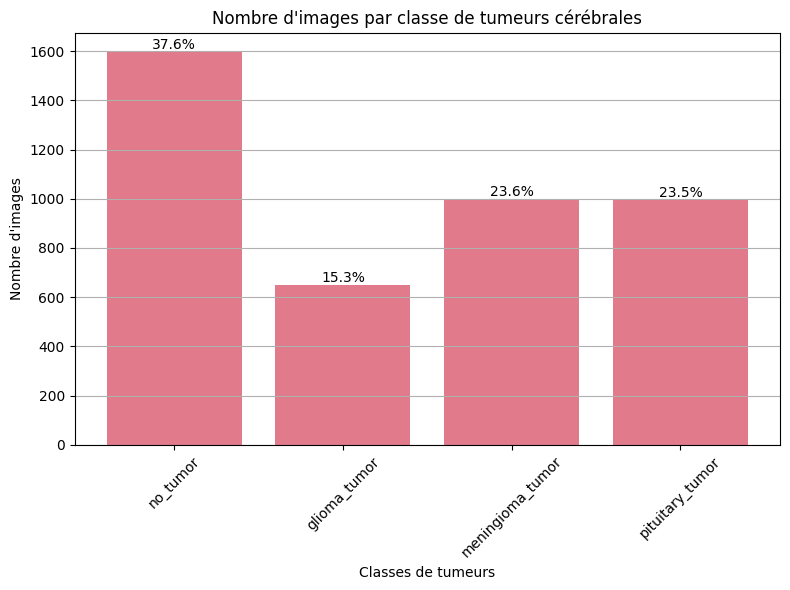

In [7]:
# Compter le nombre d'images par classe
unique, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(classes, counts))

# Calculer le total d'images et les pourcentages
total_images = sum(class_counts.values())
percentages = [(count / total_images) * 100 for count in class_counts.values()]

# Créer le diagramme à barres
plt.figure(figsize=(8, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color='#E17A8A')

# Ajouter les pourcentages au-dessus des barres
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{percentage:.1f}%', ha='center', va='bottom')

plt.xlabel('Classes de tumeurs')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par classe de tumeurs cérébrales')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Afficher le plot
plt.tight_layout()
plt.show()

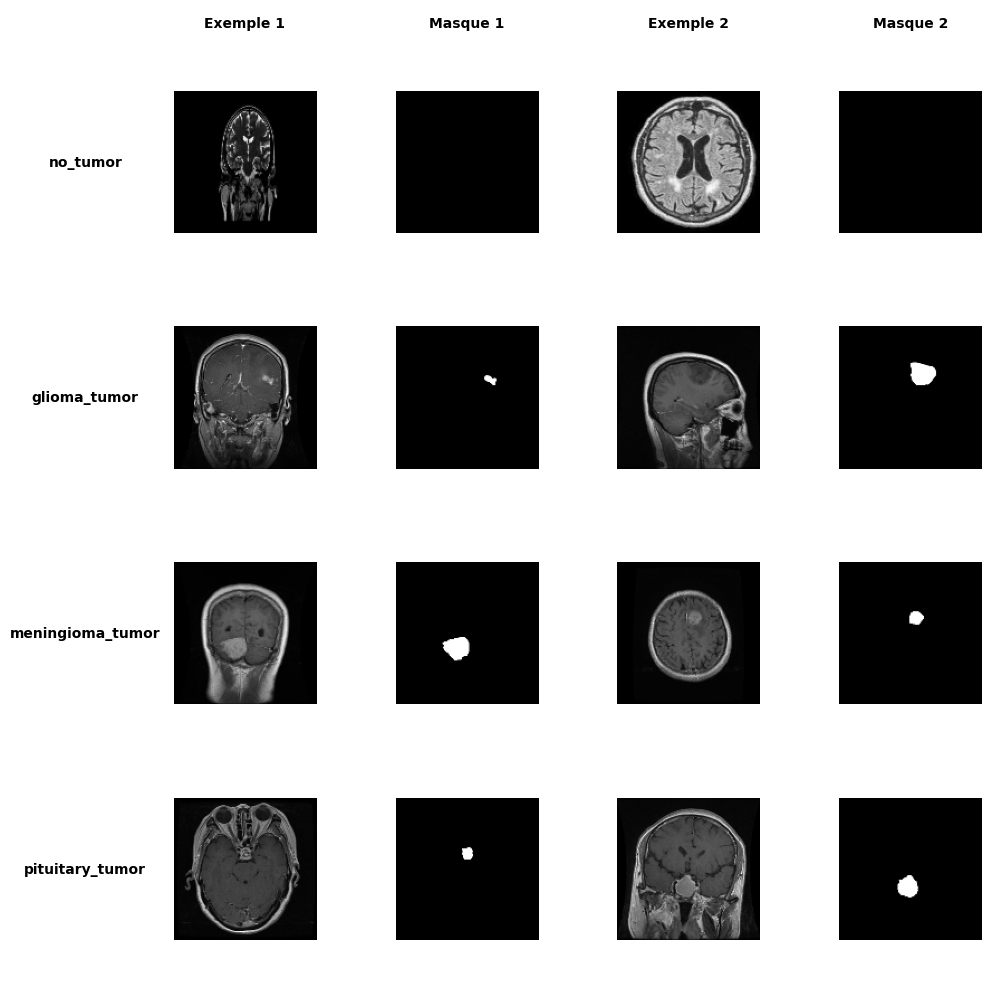

In [8]:
# Initialiser la figure avec une grille pour 4 classes
fig, axs = plt.subplots(len(classes) + 1, 5, figsize=(10, 10),
                         gridspec_kw={'width_ratios': [0.5, 4, 4, 4 ,4], 'height_ratios': [0.5, 4, 4, 4, 4]})

# Titre des colonnes
axs[0, 0].text(0.5, 0.5, "", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 0].axis('off')  # Enlever les axes

axs[0, 1].text(0.5, 0.5, "Exemple 1", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 1].axis('off')  # Enlever les axes

axs[0, 2].text(0.5, 0.5, "Masque 1", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 2].axis('off')  # Enlever les axes

axs[0, 3].text(0.5, 0.5, "Exemple 2", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 3].axis('off')  # Enlever les axes

axs[0, 4].text(0.5, 0.5, "Masque 2", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 4].axis('off')  # Enlever les axes

for i, class_name in enumerate(classes):
    # Trouver un index d'image et de masque pour chaque classe
    class_index = classes.index(class_name)

    # Récupérer un exemple d'image et de masque pour chaque classe
    example_index1 = np.where(labels == class_index)[0][0]  # Prendre le premier exemple de chaque classe
    example_index2 = np.where(labels == class_index)[0][2]  # Prendre le deuxieme exemple
    image1 = images[example_index1]
    mask1 = masks[example_index1]

    image2 = images[example_index2]
    mask2 = masks[example_index2]

    # Afficher l'image
    axs[i + 1, 1].imshow(image1, cmap='gray')
    axs[i + 1, 1].axis('off')  # Enlever les axes

    # Afficher le masque
    axs[i + 1, 2].imshow(mask1, cmap='gray')
    axs[i + 1, 2].axis('off')  # Enlever les axes

    # Afficher l'image
    axs[i + 1, 3].imshow(image2, cmap='gray')
    axs[i + 1, 3].axis('off')  # Enlever les axes

    # Afficher le masque
    axs[i + 1, 4].imshow(mask2, cmap='gray')
    axs[i + 1, 4].axis('off')  # Enlever les axes

    # Centrer le texte dans la colonne de la classe
    axs[i + 1, 0].text(0.5, 0.5, class_name, fontsize=10, ha='center', va='center', fontweight='bold')
    axs[i + 1, 0].axis('off')  # Enlever les axes

plt.tight_layout()
plt.show()


In [9]:
# Diviser les données en ensembles d'entraînement (75%) et de validation (25%)
images_train, images_val, masks_train, masks_val, labels_train, labels_val = train_test_split(
    images, masks, labels, test_size=0.3, random_state=42, stratify=labels, shuffle=True
)

# Affichage des dimensions des ensembles
print(f"Ensemble d'entraînement - Images: {images_train.shape}, Masques: {masks_train.shape}, Labels: {labels_train.shape}")
print(f"Ensemble de validation - Images: {images_val.shape}, Masques: {masks_val.shape}, Labels: {labels_val.shape}")

Ensemble d'entraînement - Images: (2965, 128, 128, 1), Masques: (2965, 128, 128, 1), Labels: (2965,)
Ensemble de validation - Images: (1272, 128, 128, 1), Masques: (1272, 128, 128, 1), Labels: (1272,)


In [10]:
# Fonction pour créer un générateur qui applique la même augmentation aux images et aux masques
def train_generator(images, masks, batch_size, seed=42):
    image_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    mask_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Générateurs pour les images et les masques
    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=seed)

    while True:
        # Génère un batch d'images et de masques
        img_batch = next(image_generator)  # Utiliser `next(image_generator)`
        mask_batch = next(mask_generator)  # Utiliser `next(mask_generator)`

        yield img_batch, mask_batch


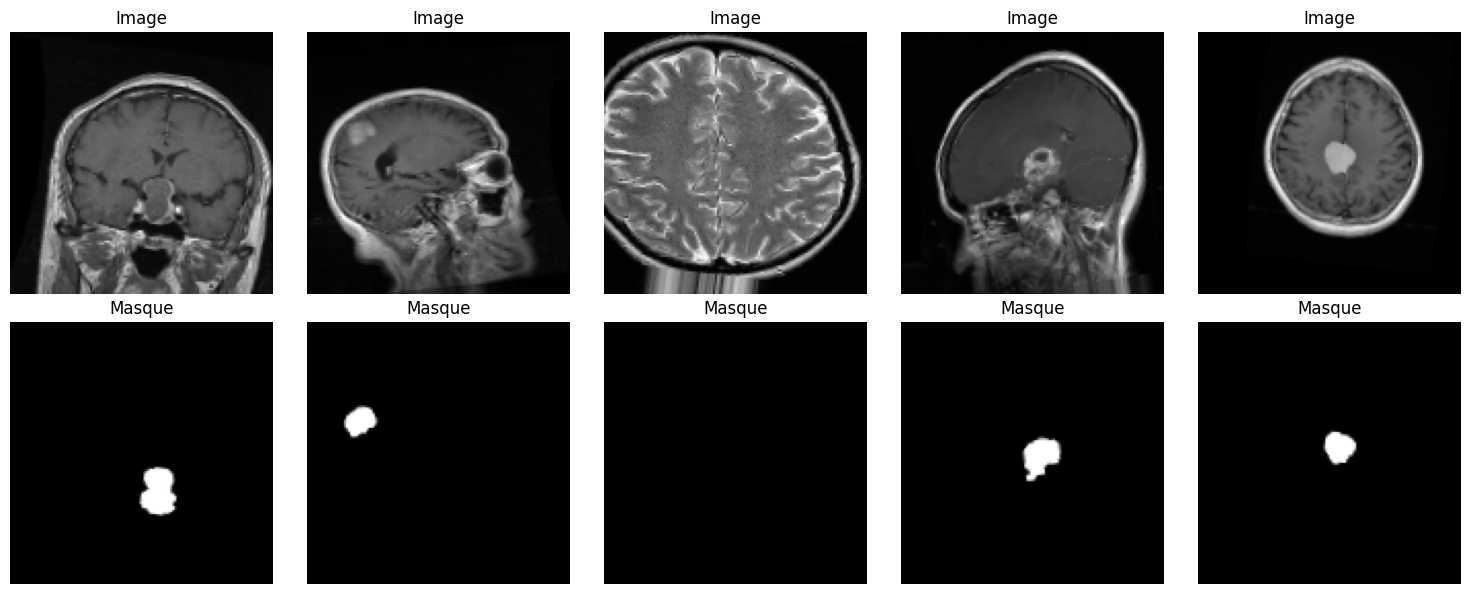

In [11]:
# Fonction pour afficher des images et leurs masques correspondants
def plot_images(images, masks, num_images=5):
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        # Afficher l'image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')  # Ajustez la forme si nécessaire
        plt.axis('off')
        plt.title('Image')

        # Afficher le masque correspondant
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(masks[i].reshape(128, 128), cmap='gray')  # Ajustez la forme si nécessaire
        plt.axis('off')
        plt.title('Masque')

    plt.tight_layout()
    plt.show()

# Tester le générateur d'augmentation en prenant quelques images
images_batch, masks_batch = next(train_generator(images_train, masks_train, batch_size=5))


# Afficher les images et les masques
plot_images(images_batch, masks_batch, num_images=5)

In [12]:
# Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Dice Loss (à utiliser comme fonction de perte)
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    total = K.sum(y_true_f) + K.sum(y_pred_f)
    union = total - intersection
    return (intersection + smooth) / (union + smooth)


In [13]:
# Définir le modèle U-Net
def unet_model(input_shape):
    inputs = layers.Input(input_shape)

    # Contratction Path
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expansive Path
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Sortie avec une seule couche, pour la segmentation binaire
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # Créer le modèle
    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model


# Définir la forme d'entrée (hauteur, largeur, canaux)
input_shape = (128, 128, 1)
model = unet_model(input_shape)
model.summary()

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy',dice_coefficient,iou])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 128)    │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 256)    │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 512)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Définir les callbacks
model_checkpoint = ModelCheckpoint('best_unetmodel.keras',  # Nom du fichier pour sauvegarder le meilleur modèle
                                   monitor='val_dice_coefficient',  # Suivre la valeur de validation du Dice Coefficient
                                   save_best_only=True,  # Sauvegarder uniquement le meilleur modèle
                                   mode='max',  # Chercher la valeur maximale
                                   verbose=1  # Afficher un message lors de la sauvegarde
                                  )

early_stopping = EarlyStopping(monitor='val_dice_coefficient',
                               patience=10,  # Arrêter après 15 époques sans amélioration
                               mode='max',  # Chercher la valeur maximale
                               verbose=1  # Afficher un message lors de l'arrêt
                              )

# Utiliser le générateur d'augmentation pour l'entraînement
batch_size = 32
train_gen = train_generator(images_train, masks_train, batch_size=batch_size)

# Entraînement du modèle avec le générateur
history = model.fit(
    train_gen,
    steps_per_epoch=len(images_train) // batch_size,
    epochs=100,
    validation_data=(images_val, masks_val),
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/100
29/92 ━━━━━━━━━━━━━━━━━━━━ 1:05:20 62s/step - accuracy: 0.9853 - dice_coefficient: 5.1718e-04 - iou: 2.7849e-04 - loss: 0.1682

In [ ]:
# Évaluation du modèle sur l'ensemble d'entrainement
train_loss, train_accuracy, train_dice_coef, train_iou_coef = model.evaluate(images_train, masks_train, verbose=1)
print(f'Training Loss: {train_loss:.4f}')
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Training Dice Coefficient: {train_dice_coef:.4f}')
print(f'Training IoU Coefficient: {train_iou_coef:.4f}')

In [ ]:
# Évaluation du modèle sur l'ensemble de validation
val_loss, val_accuracy, val_dice_coef, val_iou_coef = model.evaluate(images_val, masks_val, verbose=1)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Dice Coefficient: {val_dice_coef:.4f}')
print(f'Validation IoU Coefficient: {val_iou_coef:.4f}')

In [ ]:
# Prédictions sur un ensemble de validation
predictions = model.predict(images_val)  # Remplacez images_test par votre ensemble de test
predictions = (predictions > 0.5).astype(np.uint8)  # Binariser les prédictions

In [ ]:
# Visualiser quelques résultats
n = 5  # Nombre d'exemples à afficher
plt.figure(figsize=(15, 15))

for i in range(n):
    # Image d'entrée
    plt.subplot(n, 3, i * 3 + 1)
    plt.imshow(images_val[i+1].reshape(128, 128), cmap='gray')
    plt.title('Image d\'entrée',fontsize=10)
    plt.axis('off')

    # Masque réel
    plt.subplot(n, 3, i * 3 + 2)
    plt.imshow(masks_val[i+1].reshape(128, 128), cmap='gray')
    plt.title('Masque réel',fontsize=10)
    plt.axis('off')

    # Masque prédit
    plt.subplot(n, 3, i * 3 + 3)
    plt.imshow(predictions[i+1].reshape(128, 128), cmap='gray')
    plt.title('Masque prédit',fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
model.save('unet_model.h5')

In [ ]:
# Chemin vers le dataset de test
test_dir = '/kaggle/input/brain-tumor-classification-mri/Training'

# Charger deux images de chaque classe pour tester
test_images = []
test_labels = []

for class_name in classes:
    class_folder = os.path.join(test_dir, class_name)

    # Récupérer les noms des images de test
    image_names = os.listdir(class_folder)

    # S'assurer qu'il y a au moins 2 images
    if len(image_names) >= 2:
        for image_name in image_names[:2]:  # Prendre les deux premières images de chaque classe
            image_path = os.path.join(class_folder, image_name)

            # Charger et prétraiter l'image
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, target_size)
            image = image / 255.0
            image = np.expand_dims(image, axis=-1)  # Ajouter la dimension pour les canaux

            test_images.append(image)
            test_labels.append(class_name)

# Convertir en tableau NumPy
test_images = np.array(test_images)

# Faire des prédictions sur ces nouvelles images
test_predictions = model.predict(test_images)
test_predictions = (test_predictions > 0.5).astype(np.uint8)



# Initialiser la figure avec une grille pour chaque classe
fig, axs = plt.subplots(len(classes) + 1, 5, figsize=(15, 10),
                         gridspec_kw={'width_ratios': [0.5, 4, 4, 4, 4], 'height_ratios': [0.5] + [4]*len(classes)})

# Titre des colonnes
titles = ["Classe", "Image 1", "Masque Prédit 1", "Image 2", "Masque Prédit 2"]
for j in range(5):
    axs[0, j].text(0.5, 0.5, titles[j], fontsize=10, ha='center', va='center', fontweight='bold')
    axs[0, j].axis('off')

# Affichage des images et de leurs prédictions
for i, class_name in enumerate(classes):
    class_indices = [j for j, label in enumerate(test_labels) if label == class_name]

    if len(class_indices) >= 2:  # Vérifier s'il y a au moins 2 indices pour la classe
        example_index1 = class_indices[0]
        example_index2 = class_indices[1]

        # Afficher le nom de la classe
        axs[i + 1, 0].text(0.5, 0.5, class_name, fontsize=10, ha='center', va='center', fontweight='bold')
        axs[i + 1, 0].axis('off')  # Enlever les axes

        # Afficher la première image
        axs[i + 1, 1].imshow(test_images[example_index1].squeeze(), cmap='gray')
        axs[i + 1, 1].axis('off')  # Enlever les axes

        # Afficher le masque prédit pour la première image
        axs[i + 1, 2].imshow(test_predictions[example_index1], cmap='gray')
        axs[i + 1, 2].axis('off')  # Enlever les axes

        # Afficher la seconde image
        axs[i + 1, 3].imshow(test_images[example_index2].squeeze(), cmap='gray')
        axs[i + 1, 3].axis('off')  # Enlever les axes

        # Afficher le masque prédit pour la seconde image
        axs[i + 1, 4].imshow(test_predictions[example_index2], cmap='gray')
        axs[i + 1, 4].axis('off')  # Enlever les axes

plt.tight_layout()
plt.show()